In [25]:
import numpy
import scipy.sparse
from matplotlib import pyplot
import shadow_reconstruction
import os
import scipy.stats

pyplot.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

In [2]:
base_dirs = {
    "/home/sumner/Desktop/NumConsShadows/ladder_single_condensed_L24_M6_open": (24, 6, -0.5),
    "/home/sumner/Desktop/NumConsShadows/ladder_very_single_condensed_L24_M6_open": (24, 6, -2.0),
    "/home/sumner/Desktop/NumConsShadows/ladder_pair_condensed_L24_M6_open": (24, 6, -0.05),
}

In [3]:
data = {}

for k, (l, m, j) in base_dirs.items():
    gs = None
    all_samples = []
    for bb, _, ff in os.walk(k):
        for f in ff:
            filename = os.path.join(bb,f)
            if f.endswith('.data'):
                samples = shadow_reconstruction.Samples.load_from(filename)
                all_samples.append(samples)
            elif gs is None and f.endswith(".npz"):
                gs = numpy.load(filename)['gs']
    acc = all_samples[0]
    for s in all_samples[1:]:
        acc.add_from(s)
    acc = acc.subset(1_000)
    print("Samples: {}".format(acc.num_samples()))
    data[k] = (l,j,m,acc,gs)

Samples: 1000
Samples: 1000
Samples: 1000


In [4]:
def make_z_data(samples, nz=1, l=24, inversion_by_parts=False):
    opstring = 'ZI'*nz + (l - 2*nz)*'I'
    recon = shadow_reconstruction.Reconstruction()
    if inversion_by_parts:
        recon.use_inversion_by_parts_estimator()
    
    estimates = recon.estimate_string_for_each_sample(opstring, samples)
    return estimates

In [5]:
some_data = data["/home/sumner/Desktop/NumConsShadows/ladder_very_single_condensed_L24_M6_open"][3]

In [6]:
by_parts_vars = []
standard_vars = []

for i in range(1,10):
    by_parts_vars.append(make_z_data(some_data, nz=i, inversion_by_parts=True).var())
    standard_vars.append(make_z_data(some_data, nz=i, inversion_by_parts=False).var())

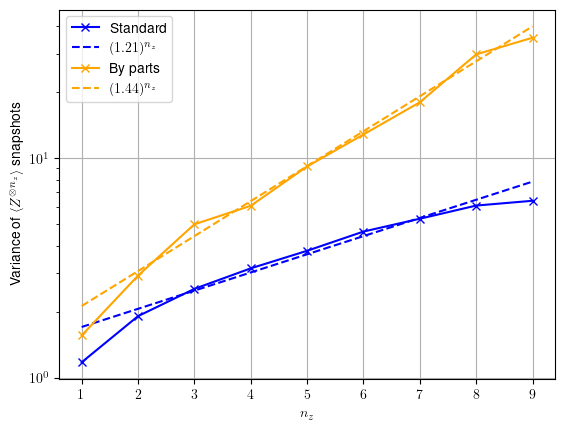

(1.443651746014295, 1.2102626156681966)

In [46]:
m1 = scipy.stats.linregress(numpy.arange(1,10)[1:-1], numpy.log(by_parts_vars)[1:-1])
m2 = scipy.stats.linregress(numpy.arange(1,10)[1:-1], numpy.log(standard_vars)[1:-1])

pyplot.plot(numpy.arange(1,10), standard_vars, 'x-', label='Standard', c='blue')
pyplot.plot(numpy.arange(1,10), numpy.exp(numpy.arange(1,10) * m2.slope + m2.intercept), '--', c='blue', label=r'$({:.2f})^{{n_z}}$'.format(numpy.exp(m2.slope)))


pyplot.plot(numpy.arange(1,10), by_parts_vars, 'x-', label='By parts', c='orange')
pyplot.plot(numpy.arange(1,10), numpy.exp(numpy.arange(1,10) * m1.slope + m1.intercept), '--', c='orange', label=r'$({:.2f})^{{n_z}}$'.format(numpy.exp(m1.slope)))
pyplot.yscale('log')
pyplot.grid()
pyplot.legend()
pyplot.ylabel(r'Variance of $\langle Z^{\otimes n_z} \rangle$ snapshots')
pyplot.xlabel('$n_z$')
pyplot.show()

numpy.exp(m1.slope), numpy.exp(m2.slope)